# What makes athletes popular? a sentiment and regression analysis
## Part III: Regression analysis of sentiment

In this project, I am using natural language processing (NLP) to try to understand what factors drive public opinion towards athletes. In [part 1](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/scrape_reddit_covariates.ipynb), I showed how to scrape reddit; in [part 2](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/master/sentiment_sports/paper/calculating_player_sentiment.ipynb), I showed how to use sentiment analysis to calculate opinion towards players. In this notebook, I will fit regression models targeting sentiment using covariates for player performance and demographics.

### How regression allows us to understand underlying factors

We know that some athletes are more popular than others, and that athletes differ in their characteristics, both intrinsic (height, age, race), and extrinsic (points scored, yards run). Given that there are dozens of these characteristics, how do we understand which ones make athletes more popular or less?

One naive approach would be to graph scatterplots of the relationship between sentiment and characteristics, as we did in part 2. This can be illuminating, and reveal obvious relationships, like how sentiment is higher for young player (NNN show graph). However, age is correlated with many other things; for example, young players usually get less playing time than the average player. Does this mean people prefer players who don't play a lot, or is something else going on? What we need is a technique that can consider all of these characteristics simultaneously.

The method we use in the project is multi-variate linear regression. This allows you to simultaneously measure how each characteristic would change sentiment, independently of each other characteristic. For example, if we find that the coefficient for age is -0.1 sentiment points per year of age, we know that no matter what a player's other characteristics are, if we were to increase their age by one year, their measured sentiment would most likely decrease.


### Aggregation

Before describing how we did the regression, let's briefly go over how we aggregate our data. Our raw data comes in the form of sentences about single players by single users. We then aggregate this data taking the mean sentiment towards each player by each user, in a given season. For players, due to the large sample size, we analyze the data at this level; for coaches, we aggregate this data one step further, and calculate the average sentiment towards each coach, across all users, for a given season (a mean of means). In addition to calculating the average sentiment at these levels, we count the number of sentences that went into that average, which we use in weighting later.

Rather than aggregate the data here, I'll just load it from disk. (I have not made this data publicly available as it has some information about individual users, but I would be happy to share it privately.)

In [1]:
import pandas as pd
%matplotlib inline
nba_df = pd.read_csv('c:/Users/map22/Google Drive/sentiment_nba/nba_user_player_sentiment.tsv', sep='\t')
nba_df = nba_df.dropna(subset=['Race', 'PPG']) # get some name matches for years players weren't playing / coaches
nba_df['rookie'] = nba_df['experience']<=1
nba_df['demean_PPG'] = nba_df['PPG'] - nba_df['PPG'].mean()
nba_df['demean_clinton'] = nba_df['clinton_vote_lead'] - nba_df['clinton_vote_lead'].mean()
nba_df['demean_race_diff'] = nba_df['white_black_diff'] - nba_df['white_black_diff'].mean()
nba_df = nba_df.replace({'M':'B', 'L':'W'}).query('Race == "W" or Race == "B"')

C:\Users\map22\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Here are what three random rows look like. We have information on the player, the commenter, the season, the measured sentiment, and an example of performance data.

In [2]:
nba_df[['Player', 'user', 'season', 'flair', 'compound_mean', 'comment_count', 'PPG']].sample(3, random_state = 24601)

,Player,user,season,flair,compound_mean,comment_count,PPG
51011,austin daye,ceeejaaay,2013,Warriors,0.0000,1,3.0
309289,emmanuel mudiay,IdRatherBeLurking,2016,[DEN] Nikola Jokic,0.2023,1,11.0
415096,jayson tatum,ReeceChops44,2017,Celtics,-0.5423,1,13.9


Let's also plot the sentiment towards players for each user, compared to the number of comments the user has.

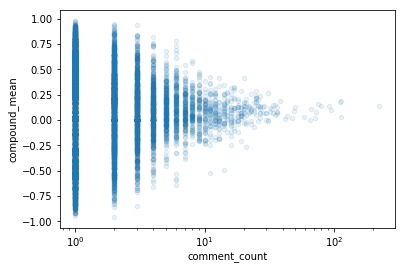

In [11]:
nba_df.sample(20000).plot.scatter('comment_count', 'compound_mean', alpha =0.1)
plt.xscale('log')

Here we can see that the variance of the sentiment estimate goes down as the number of comments goes up. We'll come back to this in a minute when we talk about weighting our regression.

### Simple regression model: unweighted, unclustered

Now we're ready to do some modeling. First, let's see if PPG is predictive of sentiment. To run our regression models, we'll use `statsmodels`'s `wls` function, and use the `formula` parameter to specify our regression. The formula parameter uses a version of R's formula, where we can specify the regression as a string. Here we are targeting our sentiment measure, `compound_mean`, and saying it is linearly related to a combination of minutes played (MP), and points per game (PPG). Once we have specified the model, we run `fit()`, and get some results!

In [3]:
import statsmodels.formula.api as smf
model = smf.wls( formula = 'compound_mean ~ MP + PPG',
                 data = nba_df,
                 weights = 1).fit()

In [4]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 01 Mar 2019   Prob (F-statistic):           1.10e-45
Time:                        20:36:54   Log-Likelihood:            -2.6926e+05
No. Observations:              848401   AIC:                         5.385e+05
Df Residuals:                  848398   BIC:                         5.386e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0700      0.001     73.923      0.000       0.068       0.072
MP         -1.125e-06   6.52e-07     -1.726      0.084    -2.4e-06    1.53e-07
PPG            0.0007   6.46e-05     11.124      0.000       0.001       0.001
==============================================================================
Omnibus:                     1033.683   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.941
Skew:                          -0.044   Prob(JB):                    3.60e-252
Kurtosis:                       3.159   Cond. No.                     5.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To interpret the results of our regression, we're going to look at two values for our features, their coefficient, and the t-statistics. For MP, we find the coefficient is ~1e-6, or approximately zero. This means that sentiment does not vary much with minutes played. Furthermore, we find the t-statistic is -1.726. For t-statistics, you want the value to be different from zero. For a 95% confidence interval we want the t-statistic to be > 1.96 or < -1.96 (two standard errors); this would mean that the coefficient is unlikely to be zero.

In contrast to MP, the PPG feature has a non-zero coefficient (0.0007), and a t-statistic of 11.1. This means that scoring points is positively (but weakly) correlated with sentiment, and the magnitude of the t-statistic means we are confident that the coefficient is different from 0.

The other thing we want to consider is how much of the variance is explained by the model. Our model is not going to be able to explain much of the variance with only two coefficients, and since many of the comments are neutral. That is why the R^2 value is basically 0. We can also compare the coefficient of PPG to the standard deviation of sentiment. The standard deviation is around NNN, which means 1 PPG is worth around 0.01 standard deviations. While it's a little disappointing to see such a low coefficient, it is still meaningful.


### Adding more features

Now that we have a sense of how to interpret coefficients, we can add more covariates. In our blog post, we show multiple specifications with increasing numbers of features. Here let's focus on our full model with all the features (all performance data scraped from [basketball-reference](http://basketball-reference.com):

* ThreePP: Three point percentage
* DWS: Defensive win share (not a rate)
* FTr: Free throw rate; hopefully a proxy for driving to the hoop
* ASTP: Assist percentage
* BLKP: Block percentage
* STLP: Steal percentage
* TOVP: Turnover percentage
* height_dummies: Dummy variables for short, medium, and tall players (NNN What are definitions?)
* rookie: whether player was in rookie year
* youth: number of years below average age (minimum 0)
* oldness: number of years above average age (minimum 0)
* Wins: team wins
* team_math: Boolean representing whether commenter had flair for team of player she was commenting on
* C(Race): boolean variable for race of player
* demean_clinton: Clinton vote percentage - Trump vote percentage for the city from the user's flair (centered around zero for interaction)
* total_population: total population of commenter's city
* demean_PPG: Points per game with mean subtracted for interaction

In [21]:
import numpy as np
model = smf.wls( formula = 'compound_mean ~ MP + ThreePP + DWS + TRBP + FTr + ASTP + BLKP + STLP + TOVP' \
                           ' + C(height_dummies) + rookie + youth + oldness + Wins + ' \
                           'team_match + C(Race) * demean_clinton +total_population + C(Race) * demean_PPG',

                data = nba_df,
               weights = 1
#                missing='raise'   
               ).fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          compound_mean   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     55.70
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          2.62e-245
Time:                        20:57:12   Log-Likelihood:            -2.3957e+05
No. Observations:              758575   AIC:                         4.792e+05
Df Residuals:                  758552   BIC:                         4.795e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0866      0.004     22.582      0.000       0.079       0.094
C(height_dummies)[T.short]      0.0061      0.002      2.824      0.005       0.002       0.010
C(height_dummies)[T.tall]     4.16e-05      0.001      0.037      0.970      -0.002       0.002
rookie[T.True]                  0.0205      0.002     12.878      0.000       0.017       0.024
team_match[T.True]              0.0042      0.001      4.521      0.000       0.002       0.006
C(Race)[T.W]                    0.0073      0.002      4.808      0.000       0.004       0.010
MP                          -4.747e-06   1.04e-06     -4.581      0.000   -6.78e-06   -2.72e-06
ThreePP                         0.0080      0.004      2.225      0.026       0.001       0.015
DWS                             0.0017      0.001      2.551      0.011       0.000       0.003
TRBP                           -0.0005      0.000     -3.312      0.001      -0.001      -0.000
FTr                            -0.0132      0.003     -4.293      0.000      -0.019      -0.007
ASTP                           -0.0002   5.72e-05     -3.206      0.001      -0.000   -7.13e-05
BLKP                            0.0008      0.000      2.116      0.034    5.65e-05       0.001
STLP                            0.0021      0.001      3.172      0.002       0.001       0.003
TOVP                           -0.0003      0.000     -2.386      0.017      -0.001   -5.01e-05
youth                           0.0023      0.000      8.922      0.000       0.002       0.003
oldness                         0.0012      0.000      7.159      0.000       0.001       0.002
Wins                        -6.033e-05   3.87e-05     -1.558      0.119      -0.000    1.56e-05
demean_clinton                  0.0077      0.003      3.043      0.002       0.003       0.013
C(Race)[T.W]:demean_clinton    -0.0022      0.005     -0.416      0.678      -0.013       0.008
total_population            -1.179e-10   9.45e-11     -1.248      0.212   -3.03e-10    6.73e-11
demean_PPG                      0.0013      0.000     12.670      0.000       0.001       0.001
C(Race)[T.W]:demean_PPG         0.0014      0.000      7.107      0.000       0.001       0.002
==============================================================================
Omnibus:                      936.893   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1054.433
Skew:                          -0.043   Prob(JB):                    1.08e-229
Kurtosis:                       3.162   Cond. No.                     1.10e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

### Adding weighting

In our initial model, we weighted all samples equally (note the `weights = 1`). However, we already know that the variance of low-comment rows is higher than high-comment rows. To handle this, we can weight our data. Now, how do we choose our weights? One way would be to weight each sample by the comment count, as if all commenters-player pairs come from the same distribution. However, this has two problems: first, we are going to be weighting high-comment users more than low comment users, even though they may not reflect general sentiment; second, we will be weighting high-comment players disproportionately to low-comment players; however, we still want to get information about these low comment players!

My solution here was to weight the 

In [3]:
import numpy as np
model = smf.wls( formula = 'compound_mean ~ MP + PPG', \
                data = nba_df,
               weights = np.sqrt(nba_df['comment_count'])
#                missing='raise'   
               ).fit()

NameError: name 'smf' is not defined

In [ ]:
model.summary()

### Adding clustering of errors